## Preprocessing 

#### if the MR is in dicom 

In [12]:
!python ./preprocessing/dicomtonifti_2.py -i ./data/dicom -o ./data/unprocessed


Looking for DICOM series in: /media/data/BrainIAC/src/BrainIAC/data/dicom
Found 2 potential scan directories
Converting scans: 100%|███████████████████████████| 2/2 [00:00<00:00, 15.50it/s]

Conversion Summary:
Successfully converted: 2 scans
Failed conversions: 0 scans
Output directory: /media/data/BrainIAC/src/BrainIAC/data


#### if the files are in nifti 

In [1]:
!python ./preprocessing/mri_preprocess_3d_simple.py \
  --temp_img ./preprocessing/atlases/temp_head.nii.gz \
  --input_dir ./data/sample/unprocessed \
  --output_dir ./data/sample/processed

Starting brain MRI preprocessing...

Step 1: Image Registration
Preloading step...
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 31.93it/s]
Registering images...
  0%|                                                     | 0/4 [00:00<?, ?it/s]Processing image 1: 00001_t1c
Saved registered image to: ./data/sample/processed/temp_registered/00001_t1c_0000.nii.gz
 25%|███████████▎                                 | 1/4 [00:26<01:18, 26.19s/it]Processing image 2: 00001_t1n
Saved registered image to: ./data/sample/processed/temp_registered/00001_t1n_0000.nii.gz
 50%|██████████████████████▌                      | 2/4 [01:16<01:20, 40.40s/it]Processing image 3: 00001_t2f
Saved registered image to: ./data/sample/processed/temp_registered/00001_t2f_0000.nii.gz
 75%|█████████████████████████████████▊           | 3/4 [02:08<00:45, 45.74s/it]Processing image 4: 00001_t2w
Saved registered image to: ./data/sample/processed/temp_registered/00001_t2w_0000.nii.gz
100%|█████████████

## BrainIAC - Feature Extraction

In [1]:
!python get_brainiac_features.py \
    --checkpoint ./checkpoints/BrainIAC.ckpt \
    --input_csv ./data/csvs/input_scans.csv \
    --output_csv ./data/output/features.csv \
    --root_dir ./data/sample/processed

BrainIAC Loaded!!
Inference: 100%|███████████████████████████████| 1/1 [00:00<00:00,  2.60batch/s]
Features saved to ./data/output/features.csv


## BrainIAC - Saliency map geneation 

In [3]:
!python get_brainiac_saliencymap.py \
    --checkpoint ./checkpoints/BrainIAC.ckpt \
    --input_csv ./data/csvs/input_scans.csv \
    --output_dir ./data/output \
    --root_dir ./data/sample/processed

BrainIAC Loaded!!
Generating saliency maps: 100%|███████████████████| 1/1 [00:01<00:00,  1.13s/it]
Saliency maps generated and saved to ./data/output


### visualize the saliency map 

(128, 128, 128) (128, 128, 128) 1.0 0.0019794104155153036


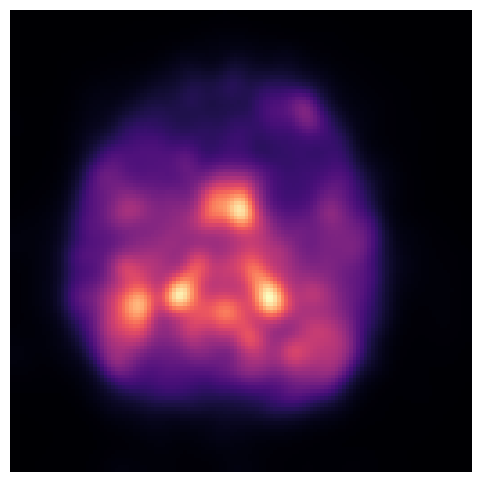

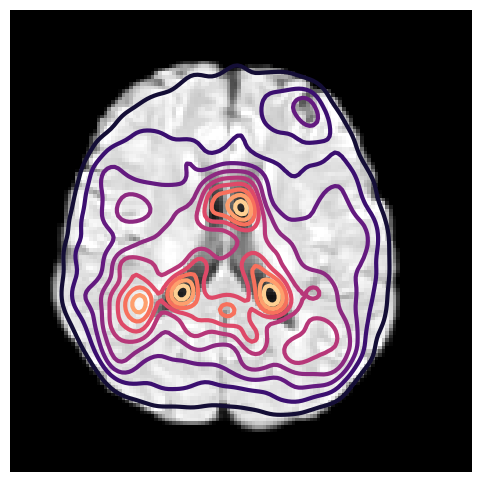

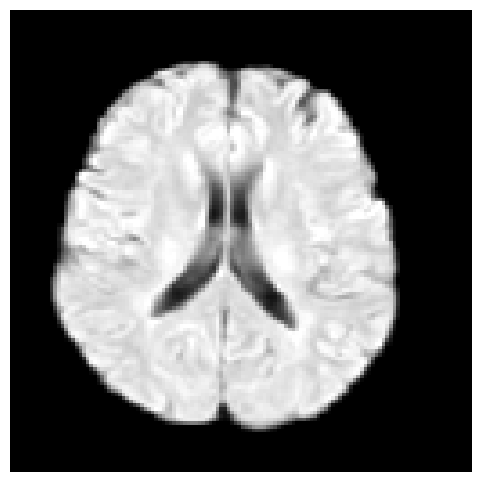

In [4]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the NIfTI files
mri_nifti_path = f'./data/output/subjectyy_000_image.nii.gz' 
saliency_nifti_path = f'./data/output/subjectyy_000_saliencymap.nii.gz'

mri_img = nib.load(mri_nifti_path)
saliency_img = nib.load(saliency_nifti_path)
mri_data = mri_img.get_fdata()
saliency_data = saliency_img.get_fdata()

print(mri_data.shape, saliency_data.shape, np.max(mri_data), np.max(saliency_data))

# Select a 2D slice based on a index number 
slice_idx = mri_data.shape[2] // 2 
mri_slice = mri_data[:, :, slice_idx]
saliency_slice = saliency_data[:, :, slice_idx]

# Normalize the MRI slice using robust normalization (1st and 99th percentiles)
def normalize_image(img):
    p1, p99 = np.percentile(img, (1, 99))
    img_clipped = np.clip(img, p1, p99)
    img_normalized = (img_clipped - p1) / (p99 - p1)
    return img_normalized

mri_slice_norm = normalize_image(mri_slice)

# Normalization function 
def normalize_saliency(saliency):
    saliency[saliency < 0] = 0
    if np.max(saliency) > 0:
        saliency_normalized = saliency / np.max(saliency)
    else:
        saliency_normalized = saliency
    return saliency_normalized

# Apply Gaussian blur to smooth the saliency map and normalize
saliency_slice_blurred = cv2.GaussianBlur(saliency_slice, (15, 15), 0)
saliency_slice_norm = normalize_saliency(saliency_slice_blurred)

# Apply a threshold to the saliency map
threshold_value = 0.0 
saliency_slice_thresholded = np.where(saliency_slice_norm > threshold_value, saliency_slice_norm, 0)

#  thresholded saliency map
plt.figure(figsize=(6, 6))
plt.imshow(saliency_slice_thresholded.T, cmap='magma', interpolation='none', origin='lower')
plt.axis('off')  

#  MRI slice with contour overlay of the thresholded saliency map
plt.figure(figsize=(6, 6))
plt.imshow(mri_slice_norm.T, cmap='gray', interpolation='none', origin='lower')
plt.contour(saliency_slice_thresholded.T, levels=10, cmap='magma', origin='lower', linewidths=3)  # Adjust the linewidth value as needed
plt.axis('off')  # Remove axis for better visualization


#  MRI slice alone (no overlay)
plt.figure(figsize=(6, 6))
plt.imshow(mri_slice_norm.T, cmap='gray', interpolation='none', origin='lower')
plt.axis('off') 


plt.show()  


## Brain age prediction

In [8]:
import yaml

# change the infer csv and model checkpoint in the config 
with open('./config.yml', 'r') as file:
    config = yaml.safe_load(file)

config['data'].update({
    'test_csv': './data/csvs/input_scans.csv', 
    'root_dir': './data/sample/processed'       
})

config['infer'].update({
    'checkpoints': './checkpoints/brainage_model.00'
})

# Save changes 
with open('./config.yml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

# infer brainage
!python -m Brainage.infer_brainage

Model and checkpoint loaded!
Inference:   0%|                                       | 0/1 [00:00<?, ?batch/s]/media/data/BrainIAC/src/BrainIAC/Brainage/infer_brainage.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/divyanshu/miniforge3/envs/brainiac/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/media/data/BrainIAC/src/BrainIAC/Brainage/infer_brainage.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result], ignore_index=True)
Inference: 100%|███████████████████████████████| 1/1 [

## Sequence classification 

#### Label map

0 - T1w 
1 - T2w 
2 - T1CE 
3 - T2 FLAIR 

In [12]:
import yaml

# change the infer csv and model checkpoint in the config 
with open('./config.yml', 'r') as file:
    config = yaml.safe_load(file)

config['data'].update({
    'test_csv': './data/csvs/input_scans.csv', 
    'root_dir': './data/sample/processed'       
})

config['infer'].update({
    'checkpoints': './checkpoints/sequenceclass_model.00'
})

# Save changes 
with open('./config.yml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

# infer brainage
!python -m SequenceClassification.infer_sequence

Model and checkpoint loaded!
Inference:   0%|                                       | 0/1 [00:00<?, ?batch/s]/media/data/BrainIAC/src/BrainIAC/SequenceClassification/infer_sequence.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/divyanshu/miniforge3/envs/brainiac/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/media/data/BrainIAC/src/BrainIAC/SequenceClassification/infer_sequence.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result], ignore_index=True)
Inference: 100%|████████

## IDH Mutation Prediction 

#### label 1 : IDH mutated , label 0 : IDH wild type 

In [18]:
import yaml

# change the infer csv and model checkpoint in the config 
with open('./config.yml', 'r') as file:
    config = yaml.safe_load(file)

config['data'].update({
    'test_csv': './data/csvs/input_scans.csv', 
    'root_dir': './data/sample/processed',
    'collate': 2        
})

config['infer'].update({
    'checkpoints': './checkpoints/idh_model.76'
})

# Save changes 
with open('./config.yml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

# infer brainage
!python -m IDHprediction.infer_idh

Model and checkpoint loaded!
Inference:   0%|                                       | 0/1 [00:00<?, ?batch/s]/media/data/BrainIAC/src/BrainIAC/IDHprediction/infer_idh.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/divyanshu/miniforge3/envs/brainiac/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/media/data/BrainIAC/src/BrainIAC/IDHprediction/infer_idh.py:150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result], ignore_index=True)
Inference: 100%|███████████████████████████████| 1/1

## Overall Survival 

## MCI Classification 

In [21]:
import yaml

# change the infer csv and model checkpoint in the config 
with open('./config.yml', 'r') as file:
    config = yaml.safe_load(file)

config['data'].update({
    'test_csv': './data/csvs/input_scans.csv', 
    'root_dir': './data/sample/processed' ,
    'collate': 1      
})

config['infer'].update({
    'checkpoints': './checkpoints/mci_model.77'
})

# Save changes 
with open('./config.yml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

# infer brainage
!python -m MCIclassification.infer_mci

Model and checkpoint loaded!
Inference:   0%|                                       | 0/1 [00:00<?, ?batch/s]/media/data/BrainIAC/src/BrainIAC/MCIclassification/infer_mci.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/divyanshu/miniforge3/envs/brainiac/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/media/data/BrainIAC/src/BrainIAC/MCIclassification/infer_mci.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result], ignore_index=True)
Inference: 100%|████████████████████████████

## Time to stroke 

In [22]:
import yaml

# change the infer csv and model checkpoint in the config 
with open('./config.yml', 'r') as file:
    config = yaml.safe_load(file)

config['data'].update({
    'test_csv': './data/csvs/input_scans.csv', 
    'root_dir': './data/sample/processed' ,
    'collate': 1      
})

config['infer'].update({
    'checkpoints': './checkpoints/stroke.03'
})

# Save changes 
with open('./config.yml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

# infer brainage
!python -m timetostroke.infer_stroke

Model and checkpoint loaded!
Inference:   0%|                                       | 0/1 [00:00<?, ?batch/s]/media/data/BrainIAC/src/BrainIAC/timetostroke/infer_stroke.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/divyanshu/miniforge3/envs/brainiac/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/media/data/BrainIAC/src/BrainIAC/timetostroke/infer_stroke.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result], ignore_index=True)
Inference: 100%|███████████████████████████████| 